In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import time
import re

%matplotlib inline

In [123]:
train=pd.read_json('train_cleaned.json')
train['listing_id']=train['listing_id'].apply(str)

In [219]:
train.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'doorman', 'features', 'features_new', 'gym',
       'hardwood', 'interest_level', 'latitude', 'laundry', 'listing_id',
       'longitude', 'manager_id', 'no_fee', 'photos', 'price', 'reduce_fee',
       'street_address', 'war', 'price_level', 'num_features', 'num_photos',
       'num_description_words', 'created_year', 'created_month',
       'created_day'],
      dtype='object')

In [125]:
train.shape

(49352, 23)

In [126]:
test=pd.read_json('test_cleaned.json')
test['listing_id']=test['listing_id'].apply(str)

#### Building count and manager count

In [127]:
building_count=pd.DataFrame({'building':train['building_id'].append(test['building_id']),
                             'count':pd.Series([1]*(train.shape[0]+test.shape[0]))}).pivot_table(index='building',
                                                                                                 values='count',
                                                                                                 aggfunc=sum)

In [128]:
building_count=pd.DataFrame(building_count)
building_count.loc['0']=1
building_count.columns=['building_listing_count']

In [129]:
manager_count=pd.DataFrame({'manager':train['manager_id'].append(test['manager_id']),
                             'count':pd.Series([1]*(train.shape[0]+test.shape[0]))}).pivot_table(index='manager',
                                                                                                 values='count',
                                                                                                 aggfunc=sum)

In [130]:
manager_count=pd.DataFrame(manager_count)
manager_count.columns=['manager_listing_count']

#### Median price of neighbor

In [131]:
train.groupby(['bedrooms']).apply(len)

bedrooms
0     9475
1    15752
2    14623
3     7276
4     1929
5      247
6       46
7        2
8        2
dtype: int64

In [11]:
def price_range(row):
    ref_df=train.copy()
    ref_df=ref_df[ref_df['bedrooms']==row['bedrooms']]
    lon=row['longitude']
    lat=row['latitude']
    ref_df['dist']=abs(ref_df['longitude']-lon)+abs(ref_df['latitude']-lat)
    neighbor_dist=np.percentile(ref_df['dist'],10)
    ref_df=ref_df[ref_df['dist']<=neighbor_dist]
    row['neighbor_median']=ref_df['price'].median()
    return row

In [48]:
t0=time()
train[train['bedrooms']==5].apply(price_range,axis=1)
print(time()-t0)

15.667223930358887


In [136]:
median_price_ref=pd.concat([train[['bedrooms','price']],test[['bedrooms','price']]]).groupby(['bedrooms']).median()['price']

In [137]:
median_price_ref

bedrooms
0     2400.0
1     2900.0
2     3350.0
3     4500.0
4     5900.0
5     8109.0
6     8000.0
7    12750.0
8     8247.5
Name: price, dtype: float64

In [138]:
def price_compare(row):
    row['price_level']=row['price']/median_price_ref.loc[row['bedrooms']]
    return row

In [139]:
train=train.apply(price_compare,axis=1)
test=test.apply(price_compare,axis=1)

#### Execute numerical feature engineering

In [140]:
def feature_engineer(df):
    df["num_features"] =df["features"].apply(len)
    df["num_photos"] =df["photos"].apply(len)
    df["num_description_words"] = df["description"].apply(lambda x: len(x.split(" ")))
    df["created"] = pd.to_datetime(df["created"])
    df["created_year"] = df["created"].dt.year
    df["created_month"] = df["created"].dt.month
    df["created_day"] = df["created"].dt.day
    df=df.merge(building_count,how='left',left_on='building_id',right_index=True).merge(manager_count,how='left',left_on='manager_id',right_index=True)
    
    return df

In [142]:
train_processed=feature_engineer(train)
test_processed=feature_engineer(test)

### Model Training

In [143]:
def feature_scaling(features):
    scaled=[]
    for feature in np.array(features).T:
        min_val=min(feature)
        max_val=max(feature)
        scaled_feature=(feature-min_val)/float(max_val-min_val)
        scaled.append(scaled_feature)
    return np.array(scaled).T

In [144]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import log_loss

#### Remove outliers

In [145]:
train_processed=train_processed[train_processed['price']<=np.percentile(train_processed['price'],99)]

#### Create features and labels array

In [146]:
target_num_map = {'high':0, 'medium':1, 'low':2}
labels=train_processed['interest_level'].apply(lambda x: target_num_map[x]).as_matrix()

#### Experiment 1: DecisionTree

In [147]:
from sklearn.tree import DecisionTreeClassifier

In [163]:
feature_names=['bedrooms','price','num_photos','longitude','latitude','price_level']
features=train_processed[feature_names].as_matrix()

In [166]:
cv=StratifiedShuffleSplit(n_splits=5, test_size=0.3)

clf=DecisionTreeClassifier(max_depth=5)

for train_idx, test_idx in cv.split(features, labels): 
    features_train,labels_train = features[train_idx],labels[train_idx]
    features_test,labels_test = features[test_idx],labels[test_idx]
    clf.fit(features_train,labels_train)
    print((-1)*log_loss(labels_test,clf.predict_proba(features_test)))



-0.698849188949
-0.698468261904
-0.707435435125
-0.701077265813
-0.705920889542


In [167]:
for i in range(len(feature_names)):
    print(feature_names[i],":",clf.feature_importances_[i])

bedrooms : 0.0111777896628
price : 0.120224277769
num_photos : 0.15323955148
longitude : 0.0901118505266
latitude : 0.0230554244634
price_level : 0.602191106098


In [168]:
param_grid = {'max_depth':[3,5,8],
              'min_samples_split':[2,3,5,8,10]
          }

clf= GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid,cv=10,scoring='neg_log_loss')

In [169]:
clf.fit(features,labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, 8], 'min_samples_split': [2, 3, 5, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [170]:
print("Best estimator found by grid search:")
print(clf.best_estimator_)

print("Best score:")
print(clf.best_score_)

Best estimator found by grid search:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Best score:
-0.698242279097


In [171]:
clf=clf.best_estimator_

In [172]:
for i in range(len(feature_names)):
    print(feature_names[i],":",clf.feature_importances_[i])

bedrooms : 0.011176231697
price : 0.116193271735
num_photos : 0.154261581982
longitude : 0.0704617897998
latitude : 0.0255456356251
price_level : 0.622361489161


#### Submission code

In [118]:
pred_result=clf.predict_proba(test_processed[feature_names].as_matrix())

In [119]:
submission=pd.DataFrame({'listing_id':test_processed['listing_id'],'high':pred_result.T[0],'medium':pred_result.T[1],'low':pred_result.T[2]})

In [69]:
submission.to_csv('submission_dt.csv',index=False)

In [119]:
# Extract tree structure from clf
'''
root=clf.tree_
n_nodes = root.node_count
children_left = root.children_left
children_right = root.children_right
feature = root.feature
threshold = root.threshold
'''

#### Experiment 2: Naive Bayes

In [84]:
from sklearn.naive_bayes import GaussianNB

In [85]:
clf=GaussianNB()

In [92]:
feature_names=['bedrooms','price','num_photos']
features=train_processed[feature_names].as_matrix()
features=feature_scaling(features)

In [93]:
cv=StratifiedShuffleSplit(n_splits=5, test_size=0.3)

for train_idx, test_idx in cv.split(features, labels): 
    features_train,labels_train = features[train_idx],labels[train_idx]
    features_test,labels_test = features[test_idx],labels[test_idx]
    clf.fit(features_train,labels_train)
    print((-1)*log_loss(labels_test,clf.predict_proba(features_test)))

0.787472415811
0.786773794246
0.781576770784
0.778475503385
0.784980624289


#### Experiment 3: Random Foreset

In [173]:
from sklearn.ensemble import RandomForestClassifier

In [201]:
feature_names=['longitude','latitude',
               'price_level','bathrooms','bedrooms','price',
               'num_photos','num_features','num_description_words',
               'hardwood','doorman','no_fee','reduce_fee','laundry','gym','war']
features=train_processed[feature_names].as_matrix()

In [202]:
clf=RandomForestClassifier(n_estimators=1000,max_depth=5)

In [203]:
cv=StratifiedShuffleSplit(n_splits=2, test_size=0.3)
for train_idx, test_idx in cv.split(features, labels): 
    features_train,labels_train = features[train_idx],labels[train_idx]
    features_test,labels_test = features[test_idx],labels[test_idx]
    clf.fit(features_train,labels_train)
    print((-1)*log_loss(labels_test,clf.predict_proba(features_test)))


-0.671963431474
-0.677917618236


In [204]:
for i in range(len(feature_names)):
    print(feature_names[i],":",clf.feature_importances_[i])

longitude : 0.0289308087806
latitude : 0.030139063176
price_level : 0.393549353188
bathrooms : 0.00655105597733
bedrooms : 0.0195617548945
price : 0.188904099587
num_photos : 0.0883306847973
num_features : 0.0145228813799
num_description_words : 0.0259108924559
hardwood : 0.050308253761
doorman : 0.00825654159077
no_fee : 0.086410001893
reduce_fee : 0.0124049295012
laundry : 0.0203996679266
gym : 0.00254198911979
war : 0.0232780219711


#### Submission

In [205]:
clf.fit(features,labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [206]:
test_features=test_processed[feature_names].as_matrix()

In [207]:
pred_result=clf.predict_proba(test_features)

In [208]:
submission=pd.DataFrame({'listing_id':test_processed['listing_id'],'high':pred_result.T[0],'medium':pred_result.T[1],'low':pred_result.T[2]})

In [209]:
submission.to_csv('submission_rf.csv',index=False)

#### Experiment 4: Neural Network

In [238]:
def feature_scaling_new(features_train,features_test):
    scaled_train=[]
    scaled_test=[]
    for i in range(len(np.array(features_train).T)):
        min_val=min(features_train.T[i])
        max_val=max(features_train.T[i])
        scaled_train_feature=(features_train.T[i]-min_val)/float(max_val-min_val)
        scaled_train.append(scaled_train_feature)
        
        scaled_test_feature=(features_test.T[i]-min_val)/float(max_val-min_val)
        scaled_test.append(scaled_test_feature)        
    return (np.array(scaled_train).T,np.array(scaled_test).T)

In [239]:
from sklearn.neural_network import MLPClassifier

In [240]:
#feature_names=['longitude','latitude','bathrooms','bedrooms','price','num_photos','num_features','num_description_words','hardwood','doorman','no_fee','reduce_fee','laundry','gym','war']
feature_names=['longitude','latitude',
               'price_level','bathrooms','bedrooms','price',
               'num_photos','num_features','num_description_words',
               'hardwood','doorman','no_fee','reduce_fee','laundry','gym','war']

features_tr=train_processed[feature_names].as_matrix()
features_te=test_processed[feature_names].as_matrix()

(features_tr,features_te)=feature_scaling_new(features_tr,features_te)

In [241]:
clf=MLPClassifier(hidden_layer_sizes=(100,100))

In [242]:
cv=StratifiedShuffleSplit(n_splits=3, test_size=0.5)
for train_idx, test_idx in cv.split(features_tr, labels): 
    features_train,labels_train = features[train_idx],labels[train_idx]
    features_test,labels_test = features[test_idx],labels[test_idx]
    clf.fit(features_train,labels_train)
    print((-1)*log_loss(labels_test,clf.predict_proba(features_test)))

-0.655872681081
-0.661951006859
-0.655237983005


#### Submission

In [244]:
clf.fit(features_tr,labels)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [245]:
pred_result=clf.predict_proba(features_te)

In [248]:
submission=pd.DataFrame({'listing_id':test_processed['listing_id'],'high':pred_result.T[0],'medium':pred_result.T[1],'low':pred_result.T[2]})

In [249]:
submission.to_csv('submission_nn.csv',index=False)

#### Other Ideas

- Use open street map and lon/lat to check the prosperity of neighborhood?

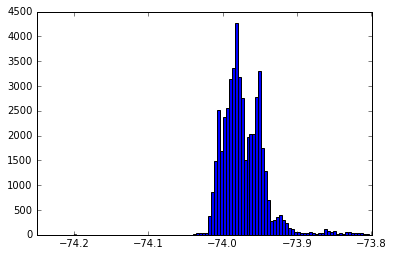

In [114]:
plt.hist(train['longitude'],range=(-74.2,-73.8),bins=100)
plt.show()